In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, shutil, random, pickle
import cv2
import keras
from sklearn.metrics import confusion_matrix
from keras import models
from keras import layers
from keras import regularizers
from keras import initializers
from keras import activations
from keras import callbacks
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

print("TensorFlow version: " + tf.__version__)
print("Keras version: " + keras.__version__)
print("Detected GPUs: " + str(tf.config.experimental.list_physical_devices('GPU')))
print("Detected CPUs: " + str(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.9.0
Keras version: 2.9.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Detected CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Configuration

In [2]:
batch_size = 128  # size of the batch
epochs = 30  # model epochs
img_rows = 32  # height of the input images
img_cols = 32  # width of the input images
output_size = 43  # number of classes (size of the one hot vector)

### Load & preprocess data

In [3]:
def hsv_eq(img, clahe):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
    v = clahe.apply(v)
    hsv = np.dstack((h, s, v))
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)    

In [4]:
def preprocess(img, eq):
    img = (img*255).astype('uint8')
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return eq(img, clahe).astype('float32') / 255.0        

In [5]:
def apply(imgs, eq):
    result = []
    for img in imgs:
        result.append(preprocess(img, eq))
    return np.array(result)

In [6]:
home = '/Users/kamil/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/Programming/Data/tsd'
models_dir = '/Users/kamil/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/Programming/Data/tsd/model'
model_name = 'tsd_class_v12_mac.h5'
data_dir = "data.pickle"

In [23]:
# raw data & variables
data = pd.read_pickle(os.path.join(home, data_dir))

x_train = apply(data['x_train'].transpose(0, 2, 3, 1), hsv_eq)
y_train = keras.utils.np_utils.to_categorical(data['y_train']).astype('float64')

x_test = apply(data['x_test'].transpose(0, 2, 3, 1), hsv_eq)
y_test = keras.utils.np_utils.to_categorical(data['y_test']).astype('float64')

x_valid = apply(data['x_validation'].transpose(0, 2, 3, 1), hsv_eq)
y_valid = keras.utils.np_utils.to_categorical(data['y_validation']).astype('float64')

labels = data['labels']

### Data visualization

In [34]:
def decode_one_hot(one_hot):
    return np.where(one_hot == 1)[0][0]

In [35]:
def percentage_one_hot(one_hot):
    return round(one_hot*100, 2)

In [36]:
def show_class_example(x_data, y_data, labels, c):
    assert len(x_data) == len(y_data)
    
    f,ax = plt.subplots(1, 2)
    f.set_size_inches(10, 5)
    f_index = 0
    
    while True:
        index = random.randint(0, len(y_data))
        if decode_one_hot(y_data[index]) == c[f_index]:
            ax[f_index].set_title(labels[c[f_index]])
            ax[f_index].imshow(x_data[index])
            f_index += 1
        
        if f_index == 2:
            break

In [39]:
def show_sample(shape, x_data, y_data, labels):
    assert shape[0] > 1 and shape[1] >1
    assert len(x_data) == len(y_data)
    
    height = 4*shape[0]
    width = 4*shape[1]
    
    f, ax = plt.subplots(shape[0], shape[1])
    f.set_size_inches(width, height)
    for y in range(shape[0]):
        for x in range(shape[1]):
            index = random.randint(0, len(x_data))
            ax[y][x].set_title(labels[decode_one_hot(y_data[index])])
            ax[y][x].imshow(x_data[index])

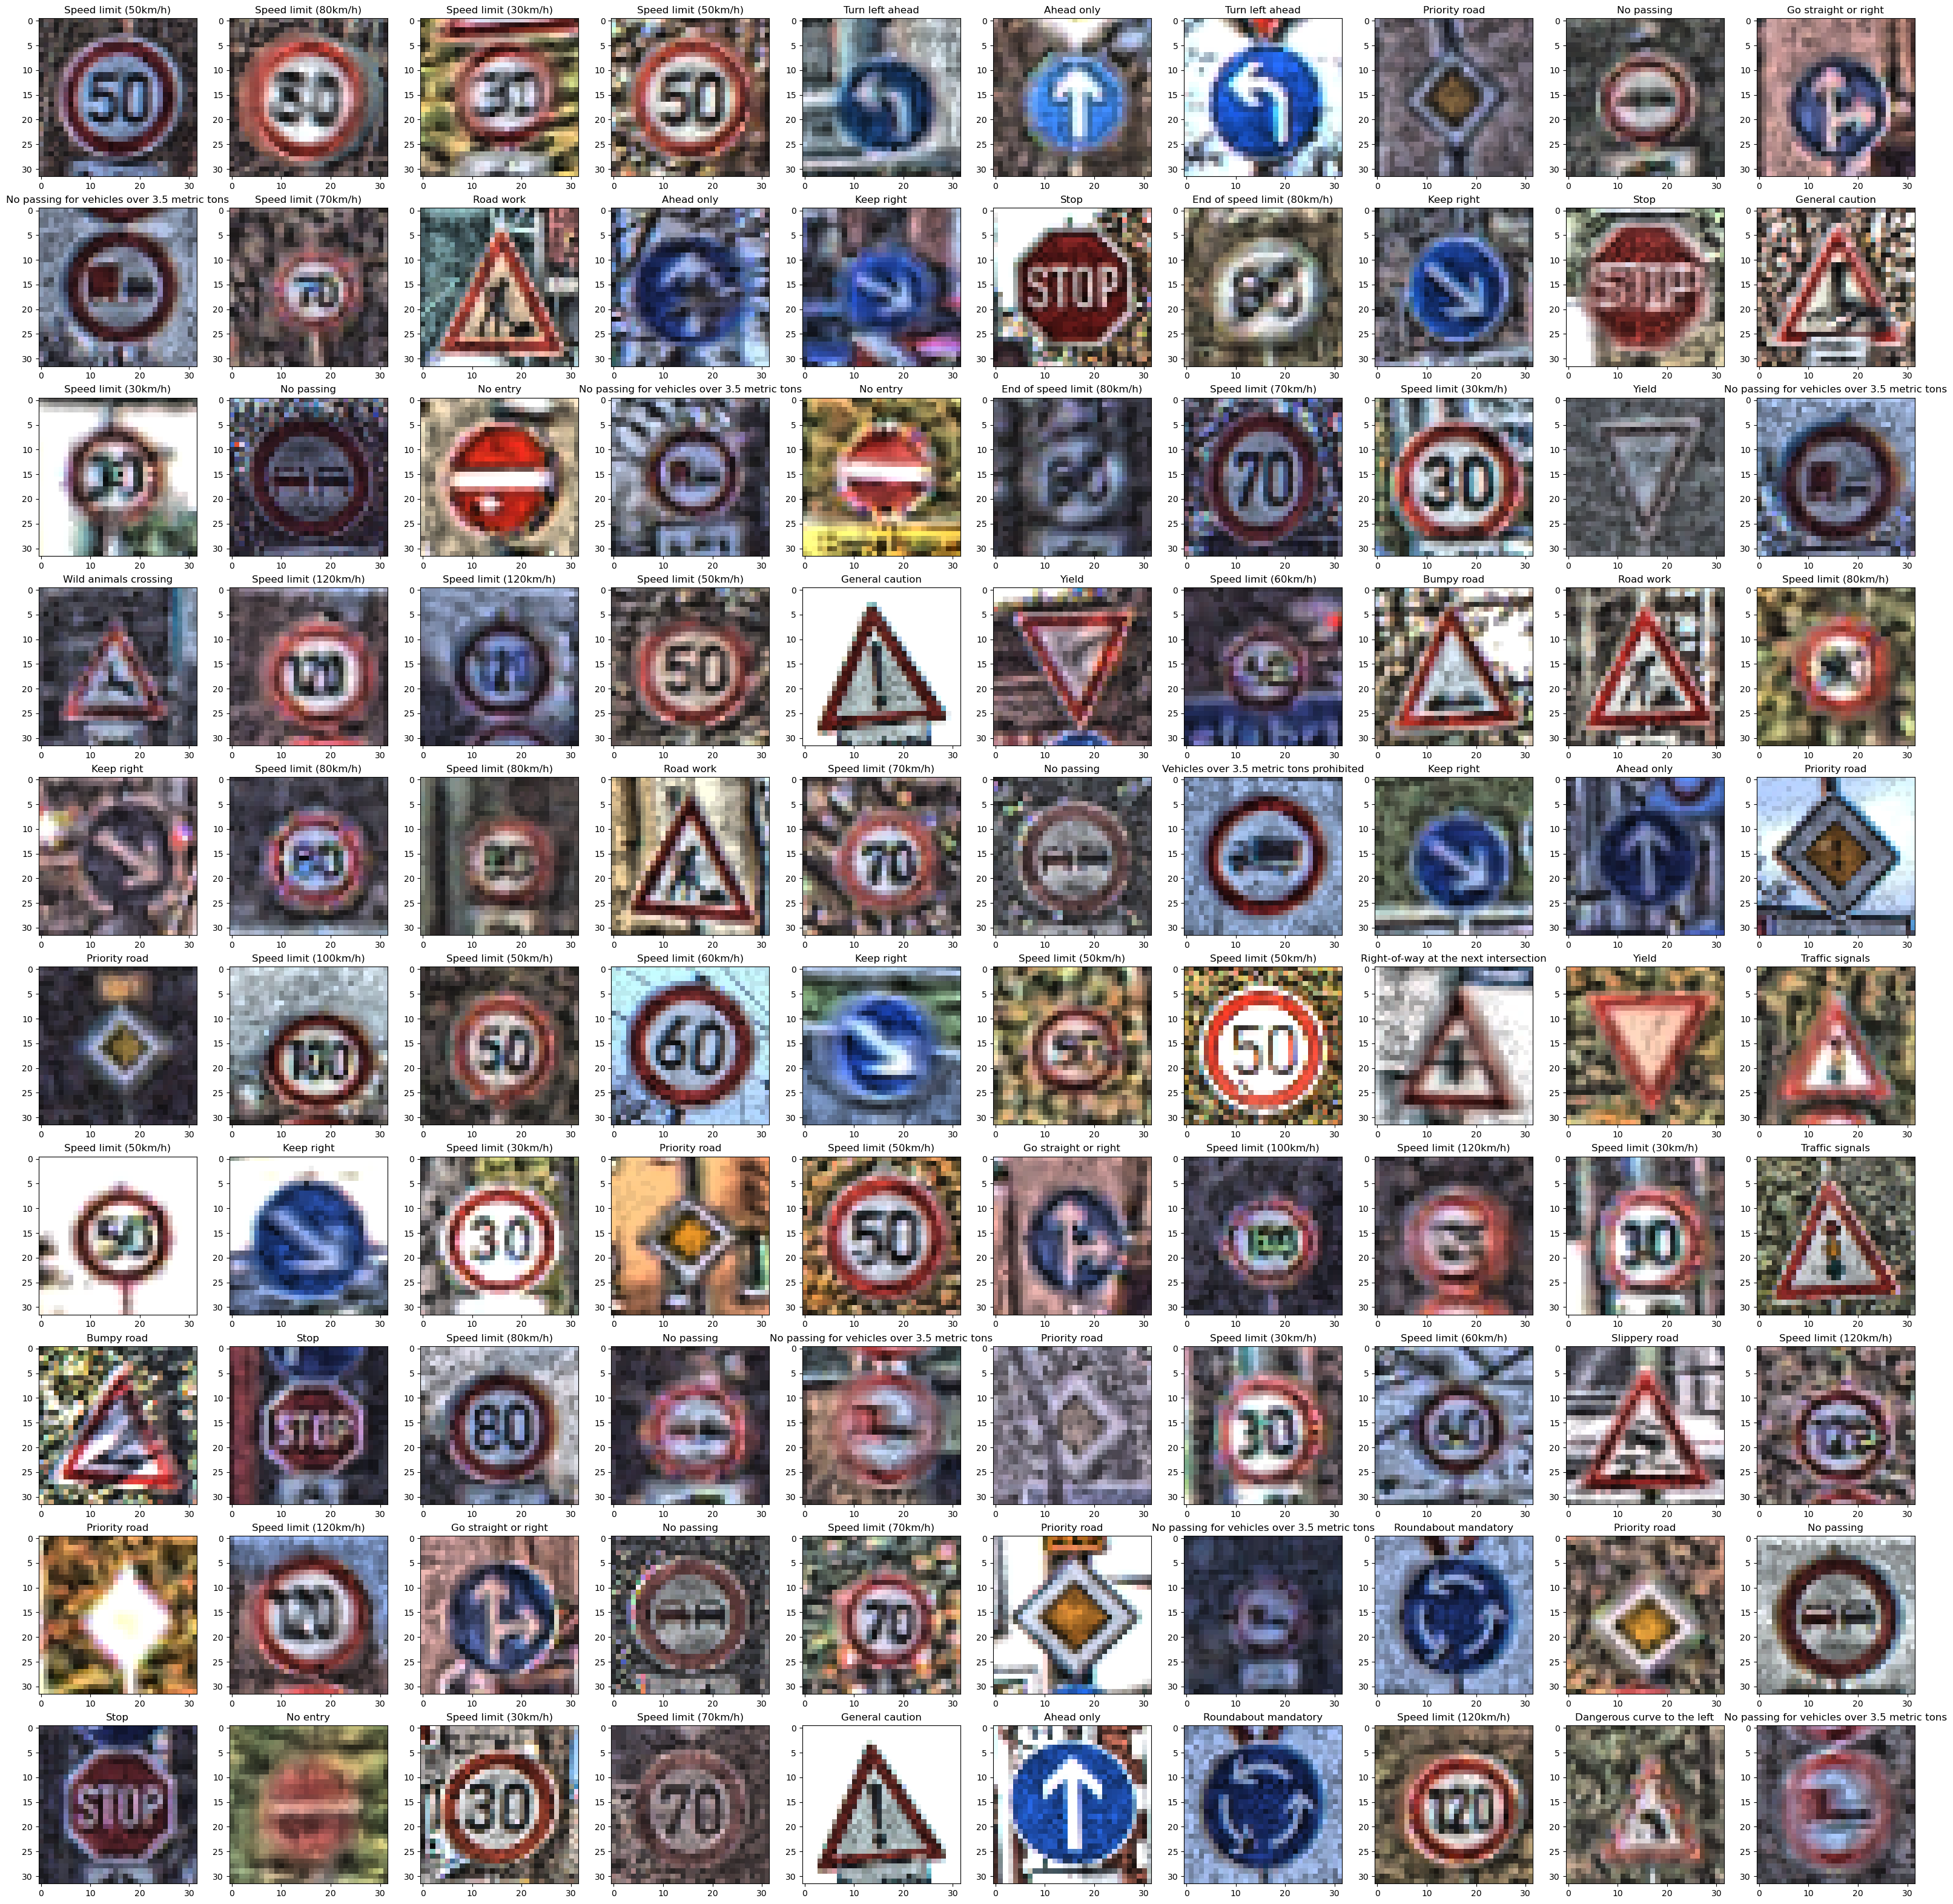

In [40]:
show_sample((10, 10), x_test, y_test, labels)

### Model

In [7]:
model = keras.models.load_model(os.path.join(models_dir, model_name))

Instructions for updating:
Colocations handled automatically by placer.
Metal device set to: Apple M1


2023-02-24 18:52:03.096081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 18:52:03.096565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-24 18:52:03.103707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-24 18:52:03.115487: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 18:52:03.120061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-24 18:52:03.150416: I tensorflow/core/grappler/optimizers/custom_graph

### Results

In [15]:
def print_evaluation(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print(f"Test accuracy: {round(acc * 100, 2)}%")
    print(f"Test loss: {round(loss, 2)}")

In [16]:
def print_confusion_matrix(model, x_test, y_test, labels):
    y_pred = model.predict(x_test, verbose=0, batch_size=batch_size)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    ticks=np.linspace(0, output_size, num=output_size+1)
    plt.clf()
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='none')
    plt.colorbar()
    plt.xticks(ticks, fontsize=6)
    plt.xlabel("Predicted")
    plt.yticks(ticks, fontsize=6)
    plt.ylabel("True")
    plt.grid(True)
    plt.show()

In [41]:
print_evaluation(model, x_test, y_test)

Test accuracy: 99.74%
Test loss: 0.08


<Figure size 640x480 with 0 Axes>

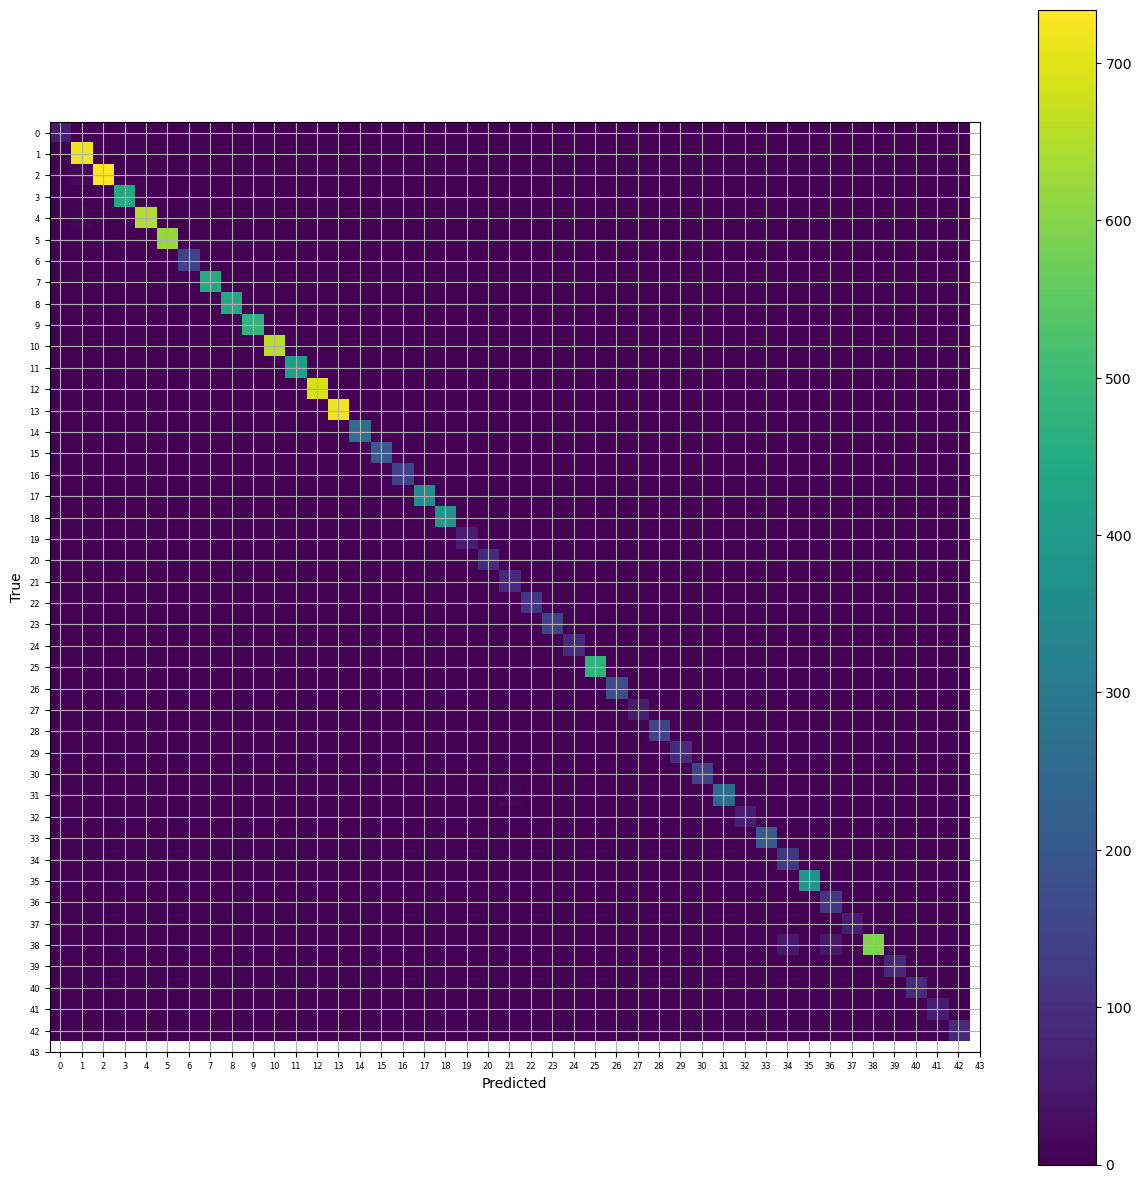

In [42]:
print_confusion_matrix(model, x_test, y_test, labels)